In [1]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

client = QdrantClient(host="localhost", port=6333)
client

In [3]:
# Let's create our first collection

my_collection = "first_collection"

first_collection = client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
)
print(first_collection)

/tmp/ipykernel_3398/895106094.py:5: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  first_collection = client.recreate_collection(


True


In [4]:
collection_info = client.get_collection(collection_name=my_collection)
list(collection_info)

[('status', <CollectionStatus.GREEN: 'green'>),
 ('optimizer_status', <OptimizersStatusOneOf.OK: 'ok'>),
 ('vectors_count', None),
 ('indexed_vectors_count', 0),
 ('points_count', 0),
 ('segments_count', 2),
 ('config',
  CollectionConfig(params=CollectionParams(vectors=VectorParams(size=100, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), qu

In [5]:
assert collection_info.status == CollectionStatus.GREEN
assert collection_info.vectors_count == None

# Adding points

In [6]:
import numpy as np

In [7]:
data = np.random.uniform(low=-1.0, high=1.0, size=(1_000, 100))
type(data[0, 0]), data[:2, :20], len(data[0])

(numpy.float64,
 array([[-0.49622436, -0.87731026,  0.58660928, -0.75762076,  0.89081941,
          0.1218586 ,  0.32954356, -0.92983731, -0.22984751,  0.11151753,
         -0.45268194, -0.38344654, -0.15383192,  0.23182934,  0.25749416,
          0.12953758,  0.59148457,  0.93869161,  0.64787172,  0.87876049],
        [-0.84992784,  0.44691987,  0.37279055, -0.98753389, -0.49200979,
         -0.42404324, -0.29072637, -0.81901619, -0.60065865, -0.91122735,
          0.63256256,  0.40934151, -0.50272507, -0.04412244, -0.00890389,
          0.94950219,  0.20544136,  0.27401321,  0.94009604,  0.38102467]]),
 100)

In [10]:
index = list(range(len(data)))
index[-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [11]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=index,
        vectors=data.tolist()
    )
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [12]:
client.retrieve(
    collection_name=my_collection,
    ids=[100],
    with_vectors=True # the default is False
)

[Record(id=100, payload={}, vector=[0.027001875, -0.028745925, -0.14806686, 0.11204794, -0.0729969, -0.10038581, 0.03957579, 0.08345343, 0.12792201, 0.11040892, 0.12261279, -0.14748073, -0.14011621, -0.011476817, -0.14125742, -0.06993953, -0.14467129, -0.009974286, 0.095987715, 0.0043333583, 0.14674732, 0.06628172, -0.08498977, 0.04948212, 0.016500253, -0.073044226, 0.12909423, -0.086358376, 0.12399652, 0.10363356, -0.124687, -0.08338513, 0.08944418, 0.07455973, -0.078024834, 0.021969963, 0.12163982, 0.08019938, 0.124659576, -0.08108801, 0.11290724, 0.024116144, 0.15944573, -0.076443166, 0.023425205, 0.05308193, -0.120317586, -0.006949328, 0.017795227, -0.046917465, -0.009669726, -0.12689309, -0.08501358, 0.09314997, 0.06779805, 0.056576755, -0.15268956, -0.10475963, -0.044377647, -0.11500048, -0.10842968, -0.15935846, 0.13274314, 0.14704421, 0.16054557, 0.083597876, 0.15701194, 0.052501388, -0.07190837, 0.10072756, -0.08059063, 0.06261614, -0.10092935, -0.014914465, 0.14062929, 0.0196

In [13]:
# update the collection one point at a time

def create_song():
    return np.random.uniform(low=-1.0, high=1.0, size=100).tolist()

client.upsert(
    collection_name=my_collection,
    points=[
        models.PointStruct(
            id=1000,
            vector=create_song(),
        )
    ]
)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

In [14]:
# We can also delete a point in a straightforward fashion.

# this will show the amount of vectors BEFORE deleting the one we just created
print(client.count(
    collection_name=my_collection, 
    exact=True,
))

client.delete(
    collection_name=my_collection,
    points_selector=models.PointIdsList(
        points=[1000],
    ),
)

print(client.count(
    collection_name=my_collection, 
    exact=True,
))

count=1001
count=1000


# Payloads

In [15]:
from faker import Faker

fake_something = Faker()
fake_something.name()

'Brittany May'

In [16]:
payload = []

for i in range(len(data)):
    payload.append(
        {
            "artist":   fake_something.name(),
            "song":     " ".join(fake_something.words()),
            "url_song": fake_something.url(),
            "year":     fake_something.year(),
            "country":  fake_something.country()
        }
    )

payload[:3]

[{'artist': 'Karen Jones',
  'song': 'responsibility second difficult',
  'url_song': 'https://yu.com/',
  'year': '2012',
  'country': 'Philippines'},
 {'artist': 'Lori Klein',
  'song': 'million specific while',
  'url_song': 'http://www.kennedy.net/',
  'year': '2018',
  'country': 'Kenya'},
 {'artist': 'Mike George',
  'song': 'daughter how blood',
  'url_song': 'https://www.luna.info/',
  'year': '2019',
  'country': 'Bosnia and Herzegovina'}]

In [32]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=index,
        vectors=data.tolist(),
        payloads=payload
    )
)

UpdateResult(operation_id=5, status=<UpdateStatus.COMPLETED: 'completed'>)

In [35]:
resutls = client.retrieve(
    collection_name=my_collection,
    ids=[10, 50, 100, 500],
    with_vectors=False
)

type(resutls), resutls

(list,
 [Record(id=10, payload={'artist': 'Ethan Daniels', 'country': 'Philippines', 'song': 'executive sister dog', 'url_song': 'https://www.robertson-ruiz.biz/', 'year': '2010'}, vector=None, shard_key=None),
  Record(id=50, payload={'artist': 'Douglas Hill', 'country': 'Holy See (Vatican City State)', 'song': 'determine several hit', 'url_song': 'https://hale.com/', 'year': '2005'}, vector=None, shard_key=None),
  Record(id=100, payload={'artist': 'Katie Kennedy', 'country': 'Djibouti', 'song': 'outside main teacher', 'url_song': 'https://henderson-bell.com/', 'year': '2006'}, vector=None, shard_key=None),
  Record(id=500, payload={'artist': 'Travis Herrera', 'country': 'Pakistan', 'song': 'which little many', 'url_song': 'https://bush.info/', 'year': '1986'}, vector=None, shard_key=None)])

# Search

In [39]:
living_la_vida_loca = create_song()

In [43]:
client.search(
    collection_name=my_collection,
    query_vector=living_la_vida_loca,
    limit=3
)

[ScoredPoint(id=330, version=5, score=0.2840498, payload={'artist': 'Tracey Garcia', 'country': 'Serbia', 'song': 'note speech director', 'url_song': 'http://rivera-donaldson.com/', 'year': '1994'}, vector=None, shard_key=None),
 ScoredPoint(id=57, version=5, score=0.27313703, payload={'artist': 'Kenneth Fields', 'country': 'Algeria', 'song': 'south record soldier', 'url_song': 'http://hart.com/', 'year': '1970'}, vector=None, shard_key=None),
 ScoredPoint(id=451, version=5, score=0.27036247, payload={'artist': 'Tony Davis', 'country': 'North Macedonia', 'song': 'others once leave', 'url_song': 'http://costa-cooper.com/', 'year': '1970'}, vector=None, shard_key=None)]

# Text Data

`pip install qdrant-client transformers datasets torch sentence-transformers`

In [45]:
from datasets import load_dataset

dataset = load_dataset("ag_news", split="train")
dataset

Generating test split: 100%|██████████| 7600/7600 [00:00<00:00, 1463509.96 examples/s]


Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

In [47]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}: {random_sample}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1: 91241
NASA scramjet to attempt Mach 10 flight NASA is hoping to break new speed records later today when it will set loose its third X-43A  quot;scramjet #39; #39; over the Pacific Ocean.

Sample 2: 93176
Specter Gets Hatch Support to Chair Panel (AP) AP - Sen. Arlen Specter gained ground Tuesday toward winning the Senate Judiciary Committee chairmanship, which was thrown into doubt after he said judges who oppose abortion rights would face confirmation problems.

Sample 3: 91904
BEA Releases Enhanced Beehive Open-Source Framework LAS VEGASBEA Systems Inc. has made significant progress in the development of the Apache Beehive component model, which is designed to help accelerate the development of Web services and SOA (service-oriented architecture) applications.

Sample 4: 72892
Tech Briefs Shares of Google rose 8.7 percent in the second trading session after the company said third-quarter profit more than doubled. The shares rose \$14.

Sample 5: 101449
Troussier for Marsei

In [52]:
id2label = {str(i): label for i, label in enumerate(dataset.features["label"].names)}
id2label

{'0': 'World', '1': 'Sports', '2': 'Business', '3': 'Sci/Tech'}

`pip install matplotlib`

<Axes: title={'center': 'Frequency with which each label appears'}, ylabel='label'>

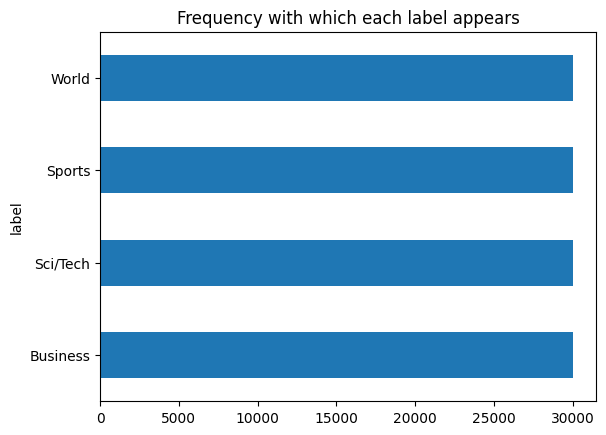

In [55]:
(
    dataset.select_columns('label')
           .to_pandas()
           .astype(str)['label']
           .map(id2label)
           .value_counts()
           .plot(kind="barh", title="Frequency with which each label appears")
)

In [56]:
def get_lenght_of_text(example):
    example['length_of_text'] = len(example['text'])
    return example

dataset = dataset.map(get_lenght_of_text)
dataset[:10]['length_of_text']

Map: 100%|██████████| 120000/120000 [00:02<00:00, 54294.20 examples/s]


[144, 266, 232, 256, 234, 239, 215, 252, 414, 147]

<Axes: title={'center': 'Distribution of the Length of News'}, ylabel='Frequency'>

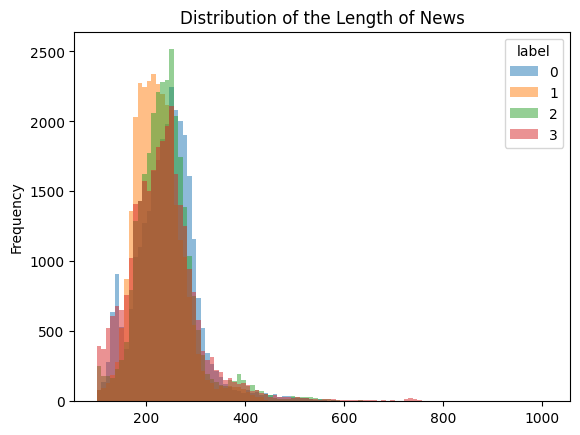

In [57]:
(
    dataset.select_columns(["label", "length_of_text"])
           .to_pandas()
           .pivot(columns='label', values='length_of_text')
           .plot.hist(bins=100, alpha=0.5, title="Distribution of the Length of News")
)

# Tokenize and embed data using GPT-2

In [60]:
from transformers import AutoModel, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModel.from_pretrained('gpt2')#.to(device) # switch this for GPU

c:\Users\Admin\HuggingFaceSharing\venv\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [63]:
tokenizer.eos_token

'<|endoftext|>'

In [64]:
tokenizer.pad_token

In [65]:
tokenizer.pad_token = tokenizer.eos_token

In [66]:
text = "What does a cow use to do math? A cow-culator."
inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")#.to(device)
inputs

{'input_ids': tensor([[ 2061,   857,   257,  9875,   779,   284,   466, 10688,    30,   317,
          9875,    12,  3129,  1352,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [67]:
toks = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
toks

['What',
 'Ġdoes',
 'Ġa',
 'Ġcow',
 'Ġuse',
 'Ġto',
 'Ġdo',
 'Ġmath',
 '?',
 'ĠA',
 'Ġcow',
 '-',
 'cul',
 'ator',
 '.']

In [68]:
tokenizer.convert_tokens_to_string(toks)

'What does a cow use to do math? A cow-culator.'

In [69]:
tokenizer.vocab_size

50257

In [70]:
with torch.no_grad():
    embs = model(**inputs)

embs.last_hidden_state.size(), embs[0]

(torch.Size([1, 15, 768]),
 tensor([[[-0.1643,  0.0957, -0.2844,  ..., -0.1632, -0.0774, -0.2154],
          [ 0.0472,  0.2181,  0.0754,  ...,  0.0281,  0.2386, -0.0731],
          [-0.1410,  0.1957,  0.5674,  ..., -0.4050,  0.1199, -0.0043],
          ...,
          [ 0.0686,  0.2000,  0.2881,  ...,  0.2151, -0.5111, -0.2907],
          [-0.0662,  0.3934, -0.8001,  ...,  0.2597, -0.1465, -0.1695],
          [-0.1900, -0.2704, -0.3135,  ...,  0.3318, -0.4120, -0.0153]]]))

In [71]:
def mean_pooling(model_output, attention_mask):

    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [72]:
embedding = mean_pooling(embs, inputs["attention_mask"])
embedding.shape, embedding[0, :10]

(torch.Size([1, 768]),
 tensor([-0.2175, -0.0280, -0.4393, -0.0739, -0.1338,  0.3550,  3.4335,  0.1762,
         -0.1412,  0.1184]))

In [73]:
def embed_text(examples):
    inputs = tokenizer(
        examples["text"], padding=True, truncation=True, return_tensors="pt"
    )#.to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [74]:
small_set = (
    dataset.shuffle(42) # randomly shuffles the data, 42 is the seed
           .select(range(1000)) # we'll take 1k rows
           .map(embed_text, batched=True, batch_size=128) # and apply our function above to 128 articles at a time
)
small_set

Map: 100%|██████████| 1000/1000 [01:47<00:00,  9.28 examples/s]


Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding'],
    num_rows: 1000
})

In [75]:
n_rows = range(len(small_set))
small_set = small_set.add_column("idx", n_rows)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx'],
    num_rows: 1000
})

In [76]:
small_set['idx'][-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [77]:
def get_names(label_num):
    return id2label[str(label_num)]

label_names = list(map(get_names, small_set['label']))
small_set = small_set.add_column("label_names", label_names)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names'],
    num_rows: 1000
})

In [78]:
dim_size = len(small_set[0]["embedding"]) # we'll need the dimensions of our embeddings
dim_size

768

# Semantic Search with Qdrant

In [80]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

client = QdrantClient(host="localhost", port=6333)
client

In [81]:
my_collection = "news_embeddings"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=dim_size, distance=models.Distance.COSINE)
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18168\2527313622.py:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [82]:
payloads = small_set.select_columns(["label_names", "text"]).to_pandas().to_dict(orient="records")
payloads[:3]

[{'label_names': 'World',
  'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'},
 {'label_names': 'Sports',
  'text': 'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.'},
 {'label_names': 'World',
  'text': 'Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.'}]

In [113]:
len(small_set["embedding"]), len(small_set["embedding"][0]), payloads

(1000,
 768,
 [{'label_names': 'World',
   'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'},
  {'label_names': 'Sports',
   'text': 'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.'},
  {'label_names': 'World',
   'text': 'Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.'},
  {'label_names': 'Sci/Tech',
   'text': 'U2 pitches for Apple New iTunes ads airing during baseball games Tuesday will feature the advertising-shy Irish rockers.'},
  {'label_names': 'World',
   'text': 'S African TV in beheading blunder Public broadcaster SABC apologises after news bulletin shows footage of American beheaded in Iraq.'},
  {'lab

In [83]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=small_set["idx"],
        vectors=small_set["embedding"],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [84]:
client.scroll(
    collection_name=my_collection, 
    limit=10,
    with_payload=False, # change to True to see the payload
    with_vectors=False  # change to True to see the vectors
)

([Record(id=0, payload=None, vector=None, shard_key=None),
  Record(id=1, payload=None, vector=None, shard_key=None),
  Record(id=2, payload=None, vector=None, shard_key=None),
  Record(id=3, payload=None, vector=None, shard_key=None),
  Record(id=4, payload=None, vector=None, shard_key=None),
  Record(id=5, payload=None, vector=None, shard_key=None),
  Record(id=6, payload=None, vector=None, shard_key=None),
  Record(id=7, payload=None, vector=None, shard_key=None),
  Record(id=8, payload=None, vector=None, shard_key=None),
  Record(id=9, payload=None, vector=None, shard_key=None)],
 10)

In [85]:
query1 = small_set[100]['embedding']
small_set[100]['text'], query1[:7]

('Stocks creep higher in New York NEW YORKUS blue-chip stocks ended barely higher yesterday as a spike in oil prices to record closing levels pared earlier gains and renewed concerns about the effect of high energy prices on consumer spending and corporate profits.',
 [0.12031644582748413,
  0.04675331711769104,
  0.1130121573805809,
  0.44551190733909607,
  0.05810481309890747,
  -0.09899602830410004,
  1.7481719255447388])

In [86]:
client.search(
    collection_name=my_collection,
    query_vector=query1,
    limit=3
)

[ScoredPoint(id=100, version=0, score=0.99999994, payload={'label_names': 'Business', 'text': 'Stocks creep higher in New York NEW YORKUS blue-chip stocks ended barely higher yesterday as a spike in oil prices to record closing levels pared earlier gains and renewed concerns about the effect of high energy prices on consumer spending and corporate profits.'}, vector=None, shard_key=None),
 ScoredPoint(id=789, version=0, score=0.9995748, payload={'label_names': 'World', 'text': 'German investor confidence surges BERLIN - German investor confidence posted a surprise jump in December as relief over falling oil prices helped to offset concerns about the impact of a surging euro on growth in Europe #39;s biggest economy.'}, vector=None, shard_key=None),
 ScoredPoint(id=379, version=0, score=0.9994168, payload={'label_names': 'Business', 'text': 'German recovery already running out of steam: research institutes (AFP) AFP - The German economy, which grew strongly in the first half of this yea

In [87]:
# Step 1 - Select Random Sample
query2 = {"text": dataset[choice(range(len(dataset)))]['text']}
query2

{'text': 'Orlovsky does his level best The thought of going to Boston College, whose football camp Dan Orlovsky attended for three years when he was in high school, was dashed when the Eagles did not offer him a scholarship.'}

In [88]:
# Step 2 - Create a Vector
query2 = embed_text(query2)['embedding'][0, :]
query2.shape, query2[:20]

((768,),
 array([ 5.9053775e-02, -9.5939092e-02, -3.4712568e-02, -2.2227207e-01,
         2.7226990e-01, -2.0691994e-01,  2.1684792e+00,  8.5256621e-02,
        -1.8585290e-01,  7.7472851e-02,  3.7598482e-01,  2.2135876e-01,
         2.1145451e-03,  7.3466830e-02,  2.9475398e-02, -3.8652301e-02,
        -1.4886381e-01, -9.3927152e-02,  9.5500819e-02, -4.2076603e-01],
       dtype=float32))

In [89]:
query2.tolist()[:20]

[0.059053774923086166,
 -0.09593909233808517,
 -0.034712567925453186,
 -0.22227206826210022,
 0.2722699046134949,
 -0.20691993832588196,
 2.1684792041778564,
 0.08525662124156952,
 -0.18585290014743805,
 0.07747285068035126,
 0.3759848177433014,
 0.2213587611913681,
 0.002114545088261366,
 0.07346682995557785,
 0.029475398361682892,
 -0.03865230083465576,
 -0.1488638073205948,
 -0.09392715245485306,
 0.09550081938505173,
 -0.42076602578163147]

In [90]:
# Step 3 - Search for similar articles. Don't forget to convert the vector to a list.
client.search(
    collection_name=my_collection,
    query_vector=query2.tolist(),
    limit=5
)

[ScoredPoint(id=710, version=0, score=0.99958, payload={'label_names': 'Sports', 'text': 'Lucchino thinks it was a bad move The president and chief executive officer of the Red Sox thinks Pedro Martinez made the wrong decision. But Larry Lucchino nonetheless had nothing but praise for the former Red Sox ace, who decided to take a more lucrative offer and join the New York Mets.'}, vector=None, shard_key=None),
 ScoredPoint(id=337, version=0, score=0.9994819, payload={'label_names': 'Sports', 'text': 'Wenger: We do not think of a catastrophe Arsene Wenger will remind his players of their 4-0 demolition of PSV when he takes his weary team to Eindhoven for what could be the defining moment in this latest Champions League campaign.'}, vector=None, shard_key=None),
 ScoredPoint(id=31, version=0, score=0.99937814, payload={'label_names': 'Sports', 'text': 'Shanahan says he intends to honour his deal with Broncos Trying to defuse rumours he might be leaving soon, Denver Broncos coach Mike Sha

In [92]:
business = models.Filter(
    must=[models.FieldCondition(key="label_names", match=models.MatchValue(value="Business"))]
)

In [93]:
client.search(
    collection_name=my_collection,
    query_vector=query2.tolist(),
    query_filter=business,
    limit=5
)

[ScoredPoint(id=923, version=0, score=0.9991886, payload={'label_names': 'Business', 'text': 'United Given New Deadline to Devise Plan A federal bankruptcy court judge on Friday gave United Airlines another 30 days to come up with a restructuring plan, but he warned the airline and its warring unions '}, vector=None, shard_key=None),
 ScoredPoint(id=364, version=0, score=0.9991561, payload={'label_names': 'Business', 'text': 'The right time for a long drive is... now MUMBAI: If you are thinking of buying a new car, you may as well bring forward your decision as interest rates on new car loans are likely to see a 25-50 basis points hike.'}, vector=None, shard_key=None),
 ScoredPoint(id=259, version=0, score=0.9991483, payload={'label_names': 'Business', 'text': "Prosecutors Want Trial to Remain in Houston Federal prosecutors Friday urged a judge in Houston to keep the fraud trial of three former Enron Corp. executives in the energy trader's hometown, saying that a fair trial is possible

# Pipeline

In [97]:
Qs = [
    "COVID-19疫苗該接種幾劑?",
    "可以選擇疫苗的廠牌嗎?",
    "COVID-19疫苗需要以同廠牌完成接種嗎?是否可交替廠牌?",
    "接種COVID-19疫苗與其他非COVID-19疫苗要間隔多久?",
    "COVID-19疫苗適合接種在哪一個年齡層?",
    "什麼時候輪到我接種？",
    "如果我不是COVID-19疫苗計畫中的接種對象、或尚未安排到接種COVID-19疫苗，我要怎麼保護自己？",
    "若我曾感染過COVID-19，我仍要接種COVID-19疫苗嗎？",
    "我對雞蛋或牛奶過敏，可以接種COVID-19疫苗嗎？",
    "我有過敏體質，可以接種COVID-19疫苗嗎?",
    "如果我在建議接種第二劑疫苗的時間未接種到疫苗怎麼辦？",
    "基礎加強劑是什麼? 什麼對象可以打基礎加強劑？",
    "追加劑是什麼? 什麼對象可以打追加劑？",
    "孕婦可否接種COVID-19疫苗?",
    "哺乳中的婦女可否接種COVID-19疫苗?",
    "兒童可否接種COVID-19疫苗?",
    "接種COVID-19疫苗有什麼注意事項？",
    "我曾經(或正在)參加COVID-19疫苗的臨床試驗, 還可以再接種COVID-19疫苗嗎?",
    "哪些人不適合接種COVID-19疫苗 (接種禁忌症)?",
    "接種COVID-19疫苗後要注意什麼？",
    "當COVID-19疫苗須接種兩劑為完整接種時，若發生第一劑接種後，但尚未到第二劑接種時，確診為SARS-CoV-2感染，康復後，應何時接種同廠牌之第二劑疫苗？",
    "需完成兩劑接種之COVID-19疫苗，若接種第一劑COVID-19疫苗後，如出現症狀經醫師評估懷疑與疫苗施打有關並通報至疾病管制署疫苗不良事件通報系統(VAERS)者，經醫師評估不適合再接種同樣疫苗時，第二劑不同廠牌之COVID-19疫苗，應間隔多久再接種？",
    "曾有血栓病史或罹患易有血栓風險的慢性疾病者，能否接種AstraZeneca (AZ) COVID-19疫苗?",
    "有心臟病史，接種mRNA COVID-19疫苗會增加心肌炎/心包膜炎的風險嗎?",
    "哪些人接種mRNA COVID-19疫苗前應先諮詢心臟科醫師?",
    "接種第㇐劑 mRNA COVID-19 疫苗後發生心肌炎/心包膜炎的人，可以接種第二劑嗎?",
    "接種mRNA COVID-19疫苗前後要注意哪些事?",
    "如果COVID-19疫苗施打的間隔不足，該怎麼辦？",
    "如果COVID-19疫苗施打的劑量不足，該怎麼辦？",
    "如果COVID-19疫苗施打的劑量過多，該怎麼辦？",
    "什麼對象可以打第二次追加劑？可以接種什麼廠牌？",
    "接種單位如遇個案體重低於同年齡平均者，是否以兒童劑型或減少劑量之COVID-19疫苗接種?"
]

In [111]:
inputs = [tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt") for text in Qs]

inputs_ebs_list = [node['input_ids'] for node in inputs]

inputs, len(inputs), inputs_ebs_list

([{'input_ids': tensor([[ 8220, 11008,    12,  1129,   163,   244,   104,   164,   233,   245,
             164,   102,   110,   162,   236,    98,   163,   101,   106, 33176,
             122, 27950,   239,    30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])},
  {'input_ids': tensor([[20998,   107, 20015,    98, 34402,   116,   162,   241,   229,   163,
             244,   104,   164,   233,   245, 21410,   161,   119,   254, 31965,
             234,   161,   245,   236,    30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1]])},
  {'input_ids': tensor([[ 8220, 11008,    12,  1129,   163,   244,   104,   164,   233,   245,
             165,   250,   222, 17358,   223, 20015,    98, 28938,   234,   161,
             119,   254, 31965,   234, 22522,   234, 22755,   238,   162,   236,
              98,   163,   101,   106,   161,   245,   236,    30, 42468, 28938,

In [ ]:
client.upsert(
    collection_name='QA_test',
    points=models.Batch(
        ids=list(range(32)),
        vectors=small_set["embedding"],
        payloads=payloads
    )
)